In [1]:
import os, sys
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

from util import basic
print("Done!")

Done!


In [134]:
import seaborn as sns

In [22]:
def load_data(data_size=1000, batch_size = 100):
    original_pos_data, original_pos_label = basic.preprocess_data("/mnt/scratch7/hirak/Attention4DNASeqRepresentation/dataset/gene_range_start_codon.txt", 1)
    original_neg_data, original_neg_label = basic.preprocess_data("/mnt/scratch7/hirak/Attention4DNASeqRepresentation/dataset/intragenic_start_codon.txt", 0)

    data_content = original_pos_data[:data_size] + original_neg_data[:data_size]
    data_label = original_pos_label[:data_size] + original_neg_label[:data_size] 

    total_datasize = len(data_content)-len(data_content)%batch_size
    rand_index = np.random.permutation(total_datasize)
    data_content = [data_content[i] for i in rand_index]
    data_label = [data_label[i] for i in rand_index]

    print(len(data_content), np.sum(data_label))
    print("Data Loader Completed")
    return (data_content, data_label)

In [23]:
data_content, data_label = load_data(data_size=5000, batch_size=5000)

10000 5000
Data Loader Completed


In [120]:
class AttnDecoderRNN(nn.Module):#corrected batch faster
    #(self, time_steps, embedding_dim, hidden_dim, vocab_size, tagset_size, mini_batch)
    def __init__(self, vocab_size, embedding_dim, \
                 hidden_dim, device, batch_size=100, debug=1, \
                 tagset_size=1, time_steps=101):
        super(AttnDecoderRNN, self).__init__()
        self.embedding_dim = embedding_dim
        self.time_steps = time_steps
        self.hidden_dim = hidden_dim
        self.minibatch_size = batch_size
        self.dropout_p = 0.25
        self.tagset_size = tagset_size
        self.hidden = self.init_hidden()
        self.debug = debug
        self.device = device 

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_one = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout_one = nn.Dropout(0.25)
        self.lstm_two = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout_two = nn.Dropout(0.25)

        self.attn_array = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for i in range(time_steps)])
        

        """
        self.attn_combine = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(self.dropout_p)
        self.linear = nn.Linear(hidden_dim, 1)
        #embedding_dim*time_steps
        """

        self.hidden2tag_one = nn.Linear(hidden_dim*time_steps, 512)
        self.dropout_three = nn.Dropout(0.25)
        self.hidden2tag_two = nn.Linear(512, 128)
        self.dropout_four = nn.Dropout(0.25)
        self.hidden2tag_three = nn.Linear(128, 64)
        self.dropout_five = nn.Dropout(0.25)

        self.output = nn.Linear(64, tagset_size)

    def forward(self, input):
        init_embed = self.embedding(input)
        #embedded = init_embed.permute(1, 0, 2)
        if self.debug == 1:
            print("Embedding Shape: ", init_embed.shape)

        lstm_out, self.hidden_one = self.lstm_one(init_embed, self.hidden)
        lstm_out = self.dropout_one(lstm_out)
        lstm_out, self.hidden_two = self.lstm_two(lstm_out, self.hidden)
        lstm_out = self.dropout_two(lstm_out)
        #"""
        lstm_permute = lstm_out.permute(1, 0, 2)
        if self.debug == 1:
            print("LSTM Out Shape: ", lstm_permute.shape)

        attention = [self.attn_array[i](lstm_permute[i][:]) for i in range(self.time_steps)]
        attention = torch.stack(attention)
        attention.to(device)
        
        attention = attention.permute(1, 0, 2)
        if self.debug == 1:
            print("Attention Shape: ", attention.shape)


        
        attn_weights = F.softmax(attention, dim=2)
        #attn_weights = attn_weights.view(self.minibatch_size, self.time_steps, 1)
        if self.debug == 1:
            print("Softmax Shape: ", attn_weights.shape)
        """
        attn_weights = torch.stack(
            [attn_weights]*self.embedding_dim, 2).view(
            self.minibatch_size, self.time_steps, -1)
        if self.debug == 1:
            print("Softmax ReShape: ", attn_weights.shape)
        """
        #attn_applied = init_embed
        attn_applied = attn_weights * init_embed
        #attn_applied = attn_applied.view(self.minibatch_size, self.time_steps, -1)
        #attn_applied = torch.sum(attn_applied, dim=1)
        if self.debug == 1:
            print("Embedding*Attention Shape: ", attn_applied.shape)

        #output = F.relu(attn_applied)
        #"""

        lstm_out = attn_applied.contiguous().view(self.minibatch_size, -1)
        #lstm_output = lstm_out.contiguous().view(self.minibatch_size, -1)
        if self.debug == 1:
            print("LSTM Output Shape: ", lstm_out.shape)


        dense_out = self.hidden2tag_one(lstm_out[:])
        dense_out = F.relu(dense_out[:])
        dense_out = self.dropout_three(dense_out[:])

        dense_out = self.hidden2tag_two(dense_out[:])
        dense_out = F.relu(dense_out[:])
        dense_out = self.dropout_four(dense_out[:])

        dense_out = self.hidden2tag_three(dense_out[:])
        dense_out = F.relu(dense_out[:])
        dense_out = self.dropout_five(dense_out[:])

        tag_space = self.output(dense_out[:])
        #print(tag_space.shape)
        #tag_scores = F.sigmoid(tag_space)
        #tag_scores = F.softmax(tag_space, dim=1)
        #print(tag_scores.shape)
        return tag_space, attn_applied, attn_weights

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(1, self.minibatch_size, self.hidden_dim, device = device),
                torch.zeros(1, self.minibatch_size, self.hidden_dim, device = device))

In [123]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
batch_size = 5000
model = AttnDecoderRNN(5, 16, 16, device, batch_size=batch_size, debug=0)
#model = model.cuda()
model.to(device)

cpu


AttnDecoderRNN(
  (embedding): Embedding(5, 16)
  (lstm_one): LSTM(16, 16, batch_first=True)
  (dropout_one): Dropout(p=0.25)
  (lstm_two): LSTM(16, 16, batch_first=True)
  (dropout_two): Dropout(p=0.25)
  (attn_array): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): Linear(in_features=16, out_features=16, bias=True)
    (6): Linear(in_features=16, out_features=16, bias=True)
    (7): Linear(in_features=16, out_features=16, bias=True)
    (8): Linear(in_features=16, out_features=16, bias=True)
    (9): Linear(in_features=16, out_features=16, bias=True)
    (10): Linear(in_features=16, out_features=16, bias=True)
    (11): Linear(in_features=16, out_features=16, bias=True)
    (12): Linear(in_features=16, out_features=

In [167]:
model.load_state_dict(
    torch.load(
      "/mnt/scratch7/hirak/Attention4DNASeqRepresentation/models/attention_model_apr_4.pt",
    map_location='cpu'
    )
   
)

In [168]:
model.eval()

AttnDecoderRNN(
  (embedding): Embedding(5, 16)
  (lstm_one): LSTM(16, 16, batch_first=True)
  (dropout_one): Dropout(p=0.25)
  (lstm_two): LSTM(16, 16, batch_first=True)
  (dropout_two): Dropout(p=0.25)
  (attn_array): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): Linear(in_features=16, out_features=16, bias=True)
    (6): Linear(in_features=16, out_features=16, bias=True)
    (7): Linear(in_features=16, out_features=16, bias=True)
    (8): Linear(in_features=16, out_features=16, bias=True)
    (9): Linear(in_features=16, out_features=16, bias=True)
    (10): Linear(in_features=16, out_features=16, bias=True)
    (11): Linear(in_features=16, out_features=16, bias=True)
    (12): Linear(in_features=16, out_features=

In [ ]:
with open()

positive_content = []

In [126]:
X = torch.from_numpy(np.array(data_content).astype(int))

In [127]:
Y = torch.from_numpy(np.array(data_label).astype(int))

In [128]:
X.shape

torch.Size([10000, 101])

In [129]:
tag_space, attn_applied, attn_weights = model.forward(X[:5000])

In [133]:
attn_weights

tensor([[[0.0560, 0.0396, 0.0942,  ..., 0.0613, 0.0768, 0.0732],
         [0.1672, 0.0480, 0.0790,  ..., 0.0854, 0.0209, 0.0398],
         [0.1919, 0.0253, 0.1858,  ..., 0.0530, 0.0191, 0.0918],
         ...,
         [0.0396, 0.0430, 0.0643,  ..., 0.0277, 0.0272, 0.1438],
         [0.0489, 0.0570, 0.0805,  ..., 0.1710, 0.0190, 0.0254],
         [0.0808, 0.0746, 0.0384,  ..., 0.0170, 0.0238, 0.1382]],

        [[0.0494, 0.0414, 0.0244,  ..., 0.0828, 0.1122, 0.0765],
         [0.0366, 0.0362, 0.0167,  ..., 0.1051, 0.0266, 0.2210],
         [0.0516, 0.0421, 0.0451,  ..., 0.1142, 0.0871, 0.1356],
         ...,
         [0.0597, 0.1060, 0.0108,  ..., 0.0079, 0.0074, 0.0815],
         [0.1169, 0.1579, 0.0482,  ..., 0.1225, 0.0459, 0.0144],
         [0.1135, 0.0856, 0.0621,  ..., 0.0109, 0.0062, 0.2002]],

        [[0.0580, 0.0667, 0.0434,  ..., 0.0364, 0.1067, 0.0883],
         [0.0269, 0.1354, 0.0256,  ..., 0.0080, 0.3488, 0.0350],
         [0.0124, 0.0874, 0.0068,  ..., 0.0138, 0.2080, 0.

In [56]:
np.where(np.any(np.array(data_label[:5000]) > 0))

(array([0]),)

In [61]:
positive_indices = [i for i,y in enumerate(data_label[:5000]) if y == 1]

In [108]:
negative_indices = [i for i,y in enumerate(data_label[:5000]) if y == 0]

In [99]:
def PCA(data, k=2):
    # preprocess the data
    # X = torch.from_numpy(data)
    X = data
    X_mean = torch.mean(X,0)
    X = X - X_mean.expand_as(X)

    # svd
    U,S,V = torch.svd(torch.t(X))
    return torch.mm(X,U[:,:k]).squeeze()


In [114]:
def get_pca_vector(indices):
    pca_attn_vec = []
    for attn in attn_applied[indices]:
        pca_attn = PCA(attn, 1)
        pca_attn_vec += [list(pca_attn.detach().numpy())]
    return pca_attn_vec

In [115]:
positive_attn_vec = get_pca_vector(positive_indices)

In [116]:
negative_attn_vec = get_pca_vector(negative_indices)

In [142]:
X

tensor([[3, 3, 3,  ..., 2, 3, 1],
        [2, 3, 3,  ..., 2, 2, 4],
        [1, 4, 2,  ..., 4, 2, 1],
        ...,
        [1, 3, 2,  ..., 2, 4, 1],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 1, 4,  ..., 1, 2, 3]])

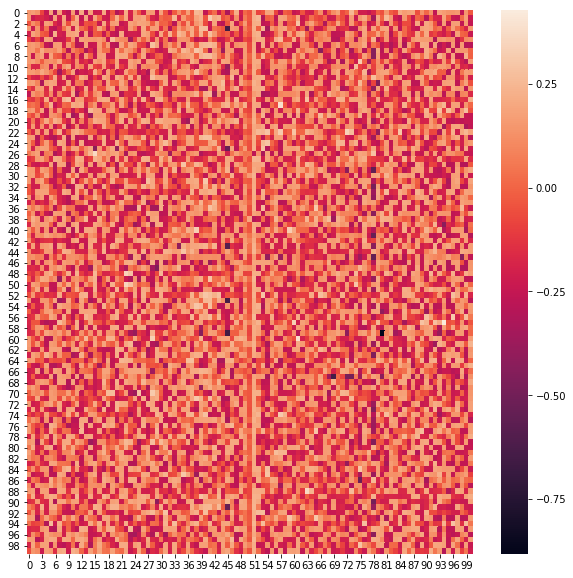

In [145]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(np.log(np.array(positive_attn_vec[:100])+1),ax = ax)

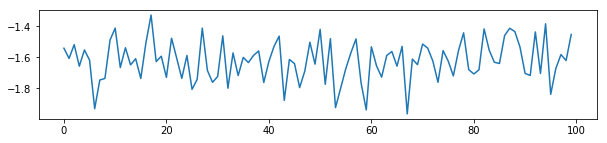

In [156]:
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(np.log(np.array(positive_attn_vec[:100])+1).sum(axis = 1))

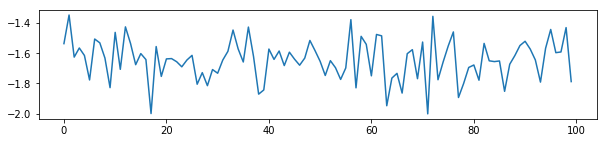

In [158]:
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(np.log(np.array(negative_attn_vec[:100])+1).sum(axis = 1))

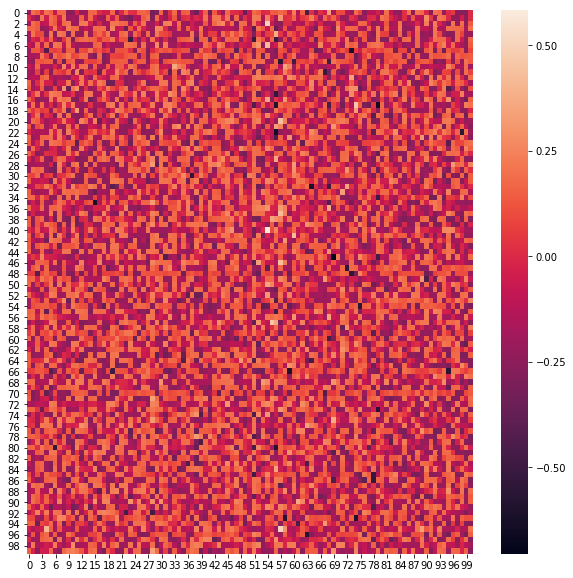

In [146]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(np.log(np.array(negative_attn_vec[:100])+1),ax = ax)

In [159]:
np.array(positive_attn_vec[:100])

0.5340215

In [163]:
seq_convert = {'N':'0', 'A':'1', 'C':'2', 'G':'3', 'T':'4'}
num_convert = {0 : 'N', 1 : 'A', 2 : 'C', 3 : 'G', 4 : 'T'}

tensor(0)

In [162]:
X.max()

tensor(4)